<a href="https://colab.research.google.com/github/rajeevfromkrec/computer-vision/blob/master/Pneumonia_Deep_learning_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model , Sequential 
from keras.layers import Dense, Flatten, Dropout, BatchNormalization,Input
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
#from Keras.optimizers import adam
from keras.preprocessing.image import  ImageDataGenerator
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import json
import zipfile

seed=232

np.random.seed(seed)
#tf.set_random_seed(seed)


Using TensorFlow backend.


In [2]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [0]:
token = {"username":"rajeevranjankrec","key":"5e8e081c0d2d711641f31c7629e1f703"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [7]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

- path is now set to: {/content}
ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge             COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-05 02:43:46          71785  
roche-data-science-coalition/uncover                          UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
rmjacobsen/property-listings-for-5-south-american-countries   Property Listings for 5 South American Countries    475MB  2020-05-25 02:05:38              1  
ruchi798/movies-on-netflix-prime-video-hulu-and-disney        Movies on Netflix, Prime Video, Hulu and Disney+    627KB  2020-05-22 23:48:01             47  
ruchi798/malnutriti

In [8]:

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/

 99% 2.28G/2.29G [00:32<00:00, 81.5MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.9MB/s]


In [9]:
!ls

chest-xray-pneumonia.zip  sample_data


In [0]:
file= zipfile.ZipFile('chest-xray-pneumonia.zip')
file.extractall()

In [12]:
os.listdir('chest_xray')

['chest_xray', 'test', 'train', '__MACOSX', 'val']

#plotting X-day pictures

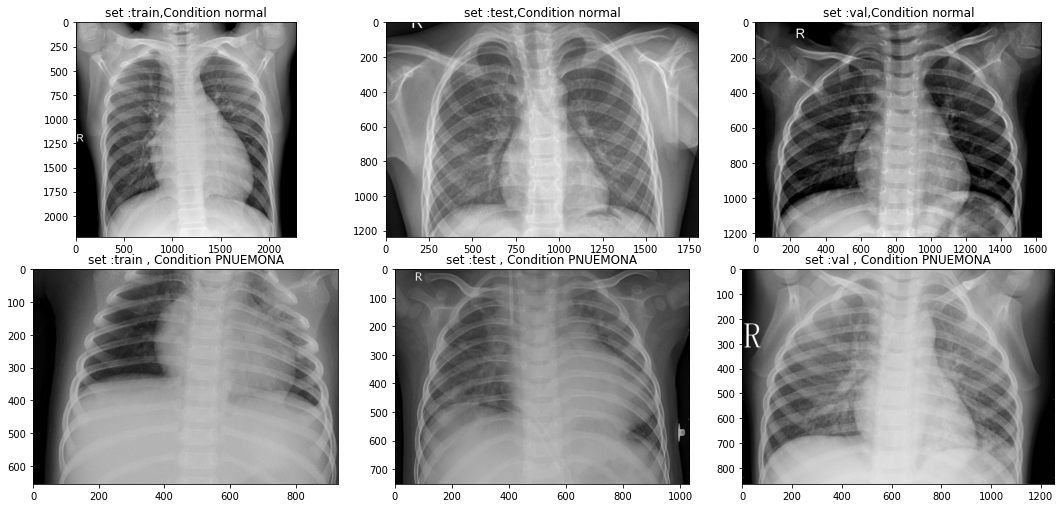

In [13]:
input_path= './chest_xray/'

fig, ax= plt.subplots(2,3, figsize=(15,7))

ax=ax.ravel()
plt.tight_layout()

for i,sub_path in enumerate(['train','test','val']):
  path=input_path+sub_path
  ax[i].imshow(plt.imread(path+'/NORMAL/'+ os.listdir(path+'/NORMAL/')[0]),cmap='gray')
  ax[i].set_title('set :{},Condition normal'.format(sub_path))
  ax[i+3].imshow(plt.imread(path+'/PNEUMONIA/'+os.listdir(path+'/PNEUMONIA/')[0]),cmap='gray')
  ax[i+3].set_title( 'set :{} , Condition PNUEMONA'.format(sub_path))





In [14]:
os.listdir(path+'/NORMAL/')[0]

'NORMAL2-IM-1440-0001.jpeg'

In [15]:
for _path in ['train','test','val']:
  normal=len(os.listdir(input_path+ _path +'/NORMAL/'))
  infected=len(os.listdir(input_path+ _path +'/PNEUMONIA/'))
  print(' {} : Normal  {}  Infected {} '.format(_path,normal,infected))



 train : Normal  1341  Infected 3875 
 test : Normal  234  Infected 390 
 val : Normal  8  Infected 8 


#building image data pipeline

In [0]:
def process_data(img_dims,batch_size):
  #data generation object
  train_datagen=ImageDataGenerator(rescale=1/255,zoom_range=0.3,vertical_flip=True)
  test_val_datagen=ImageDataGenerator(rescale=1/255)

  #this is fed to network
  train_gen=train_datagen.flow_from_directory(directory=input_path+'train', 
                                              target_size=(img_dims,img_dims),
                                              class_mode='binary',
                                              batch_size=batch_size,shuffle=True)
  
  test_gen=test_val_datagen.flow_from_directory(directory=input_path+'test', 
                                              target_size=(img_dims,img_dims),
                                              class_mode='binary',
                                              batch_size=batch_size,shuffle=True)
  
  test_data=[]
  test_labels=[]

  for cond in ['/NORMAL/','/PNEUMONIA/']:
    for img in os.listdir(input_path+'test'+cond):
      img=plt.imread(input_path+'test'+cond+img)
      img=cv2.resize(img,(img_dims,img_dims))
      img=np.dstack([img,img,img])
      img=img.astype('float32')/255
      if cond== '/NORMAL/':
        label=0
      elif cond== '/PNEUMONIA/':
        lable=1
      test_data.append(img)
      test_labels.append(label)

      return train_gen,test_gen,test_data,test_labels
      
      
  


In [17]:
image_dims=150
epochs=10
batch_size=32

train_gen, test_gen, test_data, test_labels=process_data(image_dims,batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The next step was to build the model. This can be described in the following 5 steps.

I used five convolutional blocks comprised of convolutional layer, max-pooling and batch-normalization.
On top of it I used a flatten layer and followed it by four fully connected layers.
Also in between I have used dropouts to reduce over-fitting.
Activation function was Relu throughout except for the last layer where it was Sigmoid as this is a binary classification problem.
I have used Adam as the optimizer and cross-entropy as the loss.
Before training the model is useful to define one or more callbacks. Pretty handy one, are: ModelCheckpoint and EarlyStopping.

ModelCheckpoint: when training requires a lot of time to achieve a good result, often many iterations are required. In this case, it is better to save a copy of the best performing model only when an epoch that improves the metrics ends.
EarlyStopping: sometimes, during training we can notice that the generalization gap (i.e. the difference between training and validation error) starts to increase, instead of decreasing. This is a symptom of overfitting that can be solved in many ways (reducing model capacity, increasing training data, data augumentation, regularization, dropout, etc). Often a practical and efficient solution is to stop training when the generalization gap is getting worse.

In [0]:
inputs = Input(shape=(image_dims, image_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [19]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 80s 494ms/step - loss: 0.3633 - accuracy: 0.8298 - val_loss: 0.7268 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 78s 476ms/step - loss: 0.2774 - accuracy: 0.8779 - val_loss: 0.7404 - val_accuracy: 0.6301
Epoch 3/10
163/163 [==============================] - 75s 459ms/step - loss: 0.2684 - accuracy: 0.8871 - val_loss: 0.7161 - val_accuracy: 0.3767
Epoch 4/10
163/163 [==============================] - 76s 464ms/step - loss: 0.2506 - accuracy: 0.9009 - val_loss: 0.5216 - val_accuracy: 0.8480

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
163/163 [==============================] - 75s 458ms/step - loss: 0.2300 - accuracy: 0.9101 - val_loss: 0.3266 - val_accuracy: 0.8530
Epoch 6/10
163/163 [==============================] - 75s 460ms/step - loss: 0.2116 - accuracy: 0.9197 - val_loss: 3.3373 - val_accuracy: 0.5980
Epoch 7/10
163/163 [=============================

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))